In [1]:
!mamba install t-coffee mmseqs2 -y -q

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from learnMSA.msa_hmm import Configuration, Align, Visualize, Emitter, Transitioner, Initializers, Training
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset
from learnMSA.protein_language_models import Common

2023-10-27 07:51:14.333136: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-27 07:51:14.408217: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-27 07:51:14.424776: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-27 07:51:14.792058: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvi

# Experimental demo: learnMSA + protein language model

This notebook demonstrates how to align a set of protein sequences with learnMSA supported by a large, pre-trained protein language model.

This configuration of learnMSA - although a prototype - is the most accurate variant of learnMSA currently available. It is also the most computationally expensive. It is recommended to run this notebook on a GPU.

In [9]:
# Your fasta file with unaligned sequences.

#train_filename = "test/data/egf.fasta"
train_filename = "../../snakeMSA/data/homfam/train/peroxidase"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
#ref_filename = "test/data/egf.ref"
ref_filename = "../../snakeMSA/data/homfam/refs/peroxidase"

# The number of independently trained models.
num_models = 10

HMM training supported by protein embeddings:

In [10]:
def align(filename, out_filename):
    scoring_model_config = Common.ScoringModelConfig(dim=32, activation="sigmoid", suffix="_100")
    config = Configuration.make_default(num_models, use_language_model=True, scoring_model_config=scoring_model_config)
    # we have to define a special model- and batch generator if using a language model
    # because the emission probabilities are computed differently and the LM requires specific inputs
    model_gen = Training.make_generic_embedding_model_generator(config["scoring_model_config"].dim)
    batch_gen = Training.EmbeddingBatchGenerator(config["scoring_model_config"])
    with SequenceDataset(train_filename, fmt="fasta") as data:
        alignment_model = Align.run_learnMSA(data,
                                            out_filename,
                                            config, 
                                            model_generator=model_gen,
                                            batch_generator=batch_gen,
                                            sequence_weights=Align.compute_sequence_weights(train_filename, "tmp", config["cluster_seq_id"]),
                                            verbose=True,
                                            align_insertions=True)
    return alignment_model

Loading scoring model  new_scoring_models_frozen/esm2_32_sigmoid_100/checkpoints
Training of 10 models on file peroxidase
Configuration: 
{
num_models : 10
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPr

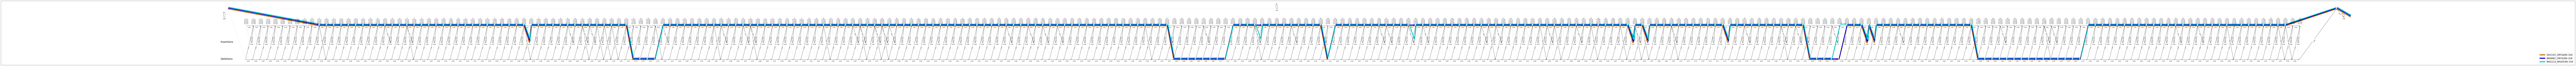

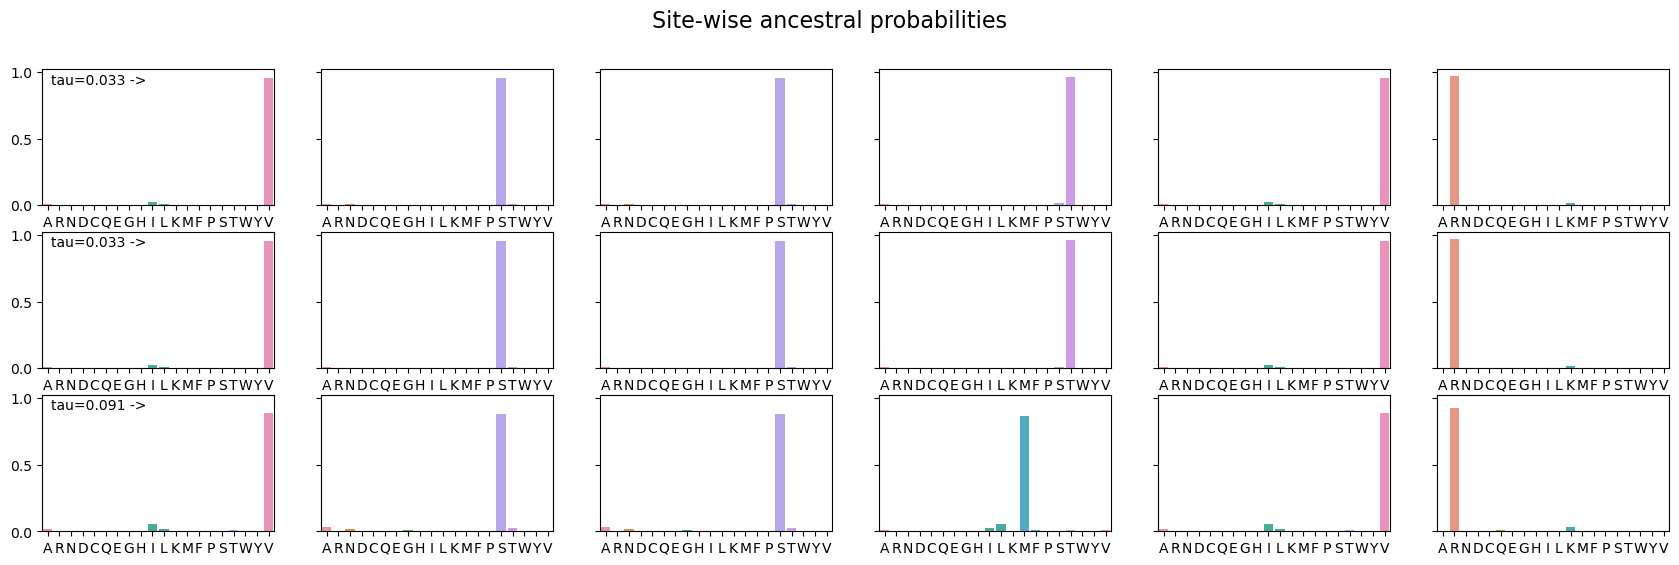

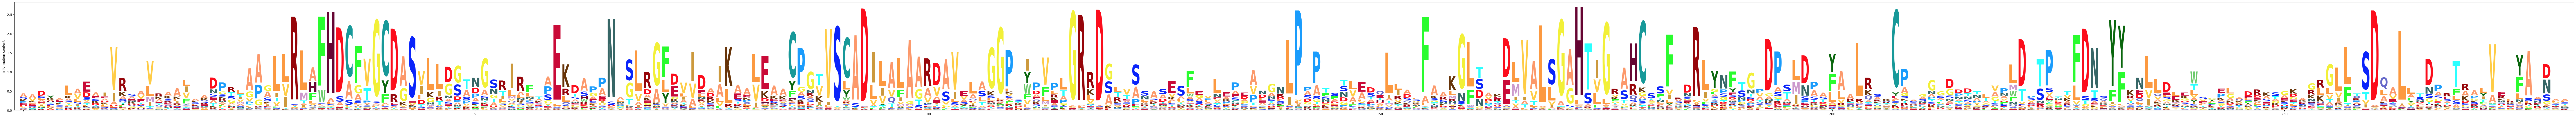

In [11]:
alignment_model = align(train_filename, "test/data/interactive.alignment.fasta") 
Visualize.print_and_plot(alignment_model, alignment_model.best_model)

In [16]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

In [17]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp

ERROR: test/data/interactive.projection.fasta FILE is NOT a supported format [ERROR]


*************************************************************************************************
*                        FULL TRACE BACK PID: 23582                                    
23591 -- ERROR: UNSPECIFIED UNSPECIFIED
23591 -- COM: /var/tmp/tco/tco37yrryf223582/46884235826.pl test/data/interactive.projection.fasta > /var/tmp/tco/tco37yrryf223582/46884235821 
23591 -- STACK: 23582 -> 23591
*************************************************************************************************

# TERMINATION STATUS: FAILURE [PROGRAM: T-COFFEE pid 23582 ppid 6987
#CL: t_coffee -other_pg aln_compare -al1 ../../snakeMSA/data/homfam/refs/peroxidase -al2 test/data/interactive.projection.fasta -compare_mode sp 
